# Projet Neural Network - Corporación Favorita Grocery Sales Forecasting

Brick-and-mortar grocery stores are always in a delicate dance with purchasing and sales forecasting. Predict a little over, and grocers are stuck with overstocked, perishable goods. Guess a little under, and popular items quickly sell out, leaving money on the table and customers fuming.

The problem becomes more complex as retailers add new locations with unique needs, new products, ever transitioning seasonal tastes, and unpredictable product marketing. Corporación Favorita, a large Ecuadorian-based grocery retailer, knows this all too well. They operate hundreds of supermarkets, with over 200,000 different products on their shelves.

Corporación Favorita has challenged the Kaggle community to build a model that more accurately forecasts product sales. They currently rely on subjective forecasting methods with very little data to back them up and very little automation to execute plans. They’re excited to see how machine learning could better ensure they please customers by having just enough of the right products at the right time.

## I - Imports

In [1]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import random as rd
from tqdm import tqdm

from neural_network import neural_net_model

/Users/louisgiron/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
/Users/louisgiron/Desktop/ENSAE - Mastère spé/Reseaux de neurones/projet_nn/processing_data.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  train_small['unit_sales'] = train_small['unit_sales'].apply(lambda x:


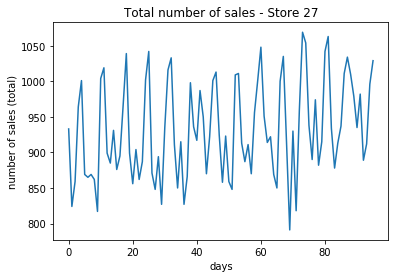

              Number of missing values  Share of missing
id                                   0              0.00
date                                 0              0.00
store_nbr                            0              0.00
item_nbr                             0              0.00
unit_sales                           0              0.00
onpromotion                    4000000            100.00
city                                 0              0.00
state                                0              0.00
type_x                               0              0.00
cluster                              0              0.00
dcoilwtico                     1346707             33.67
type_y                         3746290             93.66
locale                         3746290             93.66
locale_name                    3746290             93.66
description                    3746290             93.66
transferred                    3746290             93.66
family                         

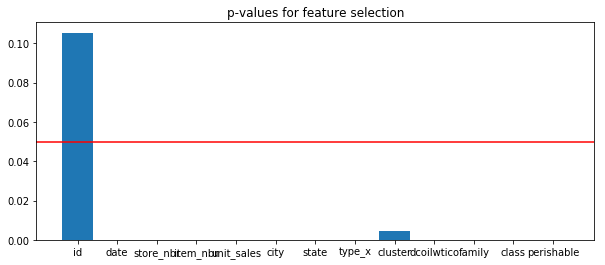

X train original shape: (125497040, 6)
X train processed shape: (4000000, 13)


In [2]:
from processing_data import train_all_processed

## II - Training setup

In [3]:
# Train size
train_size = 0.7

# Split the train data to learn # Warning date -> split linearly
X_train = train_all_processed.drop(['unit_sales'],
                                   axis=1).loc[range(int(train_all_processed.shape[0]*train_size))]
y_train = train_all_processed['unit_sales'].loc[range(int(train_all_processed.shape[0]*train_size))]
X_test = train_all_processed.drop(['unit_sales'],
                                   axis=1).loc[range(int(train_all_processed.shape[0]*train_size),
                                               int(train_all_processed.shape[0]))]
y_test = train_all_processed['unit_sales'].loc[range(int(train_all_processed.shape[0]*train_size),
                                               int(train_all_processed.shape[0]))]
# Norlmalize data
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train.values)
y_train_norm = scaler.fit_transform(y_train.values.reshape(-1, 1))

X_test_norm = scaler.fit_transform(X_test.values)
y_test_norm = scaler.fit_transform(y_test.values.reshape(-1, 1))

print(X_train.shape)
print(np.max(X_train_norm), np.max(y_train_norm), np.min(y_train_norm),
      np.min(y_train_norm))


def denormalize(y_train, norm_data):
    try:
        df = y_train.values.reshape(-1, 1)
    except AttributeError:
        df = y_train.reshape(-1, 1)
    norm_data = norm_data.reshape(-1, 1)
    scl = MinMaxScaler()
    scl.fit_transform(df)
    return scl.inverse_transform(norm_data)


# Input data
nb_input = X_train.shape[1]
nb_hidden1 = 64
nb_hidden2 = 64
batch_size = 10000
nb_epoch = 30

(2800000, 12)
1.0 1.0 0.0 0.0


## III - Model initialization

In [4]:
# Initialize the model
X_tf = tf.placeholder(tf.float32)
y_tf = tf.placeholder(tf.float32)
keep_prob_1 = tf.placeholder(tf.float32)
keep_prob_2 = tf.placeholder(tf.float32)

output, W_O = neural_net_model(X_tf, nb_input, nb_hidden1, nb_hidden2,
                               keep_prob_1, keep_prob_2)

cost = tf.reduce_mean(tf.square(output-y_tf))
train = tf.train.AdamOptimizer(0.001).minimize(cost)

correct_pred = tf.argmax(output, 1)
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

c_t = []
c_test = []
err_t = []  # norm l2
err_test = []

# Drop out level
prob_1 = 0.1
prob_2 = 0.1

prob_out = 1.0

## IV - Model training

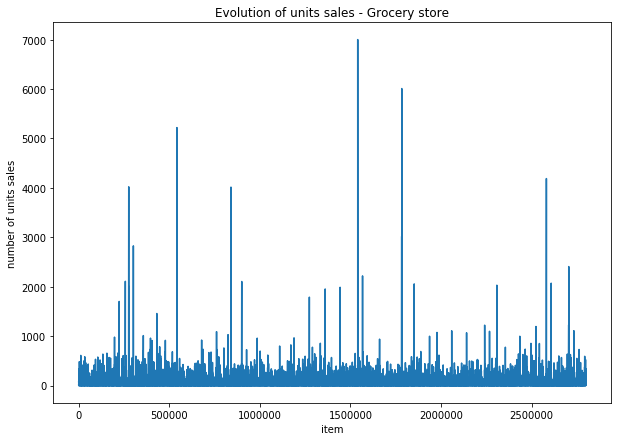

  3%|▎         | 1/30 [00:06<02:59,  6.19s/it]

Epoch : 0 Cost : 1.677035 Err (l2) : 46125.11584202813


  7%|▋         | 2/30 [00:12<02:51,  6.13s/it]

Epoch : 1 Cost : 0.024896596 Err (l2) : 13994.25687889607


 10%|█         | 3/30 [00:18<02:44,  6.09s/it]

Epoch : 2 Cost : 0.00023573222 Err (l2) : 1511.234441643211


 13%|█▎        | 4/30 [00:24<02:37,  6.08s/it]

Epoch : 3 Cost : 0.00017638975 Err (l2) : 1737.0931554488443


 17%|█▋        | 5/30 [00:30<02:31,  6.06s/it]

Epoch : 4 Cost : 7.56383e-06 Err (l2) : 1405.7174256661854


 20%|██        | 6/30 [00:36<02:25,  6.06s/it]

Epoch : 5 Cost : 7.4548174e-05 Err (l2) : 1824.9268556305565


 23%|██▎       | 7/30 [00:42<02:19,  6.05s/it]

Epoch : 6 Cost : 8.509663e-06 Err (l2) : 1253.7539723160085


 27%|██▋       | 8/30 [00:48<02:13,  6.07s/it]

Epoch : 7 Cost : 0.0014016306 Err (l2) : 3186.066248009975


 30%|███       | 9/30 [00:54<02:07,  6.09s/it]

Epoch : 8 Cost : 0.00095162075 Err (l2) : 1079.0861674332186


 33%|███▎      | 10/30 [01:00<02:01,  6.09s/it]

Epoch : 9 Cost : 0.00014078943 Err (l2) : 1672.7230906291338


 37%|███▋      | 11/30 [01:06<01:55,  6.10s/it]

Epoch : 10 Cost : 6.040922e-06 Err (l2) : 1413.3015255049802


 40%|████      | 12/30 [01:12<01:49,  6.10s/it]

Epoch : 11 Cost : 4.206337e-06 Err (l2) : 1624.337657714043


 43%|████▎     | 13/30 [01:19<01:43,  6.10s/it]

Epoch : 12 Cost : 0.00010943138 Err (l2) : 7323.715351073027


 47%|████▋     | 14/30 [01:25<01:37,  6.11s/it]

Epoch : 13 Cost : 1.3104689e-05 Err (l2) : 2320.881081417551


 50%|█████     | 15/30 [01:31<01:31,  6.13s/it]

Epoch : 14 Cost : 5.626279e-05 Err (l2) : 1188.2460553201583


 53%|█████▎    | 16/30 [01:37<01:25,  6.12s/it]

Epoch : 15 Cost : 1.2383966e-05 Err (l2) : 1651.4360828153422


 57%|█████▋    | 17/30 [01:43<01:19,  6.13s/it]

Epoch : 16 Cost : 3.7442383e-06 Err (l2) : 1242.9947958153168


 60%|██████    | 18/30 [01:49<01:13,  6.14s/it]

Epoch : 17 Cost : 3.073371e-06 Err (l2) : 1359.2207640679724


 63%|██████▎   | 19/30 [01:55<01:07,  6.13s/it]

Epoch : 18 Cost : 4.552705e-06 Err (l2) : 1612.398607792779


 67%|██████▋   | 20/30 [02:01<01:01,  6.12s/it]

Epoch : 19 Cost : 5.100978e-06 Err (l2) : 1615.5528951018307


 70%|███████   | 21/30 [02:08<00:55,  6.11s/it]

Epoch : 20 Cost : 7.88225e-06 Err (l2) : 2119.3309841233186


 73%|███████▎  | 22/30 [02:14<00:48,  6.10s/it]

Epoch : 21 Cost : 6.5785885e-06 Err (l2) : 1963.1721783228284


 77%|███████▋  | 23/30 [02:20<00:42,  6.10s/it]

Epoch : 22 Cost : 1.4854569e-05 Err (l2) : 1220.5300255443362


 80%|████████  | 24/30 [02:26<00:36,  6.11s/it]

Epoch : 23 Cost : 4.4751237e-06 Err (l2) : 1608.447550443021


 83%|████████▎ | 25/30 [02:32<00:30,  6.12s/it]

Epoch : 24 Cost : 4.3603764e-06 Err (l2) : 1708.2680728690393


 87%|████████▋ | 26/30 [02:38<00:24,  6.12s/it]

Epoch : 25 Cost : 4.5406246e-06 Err (l2) : 1637.8756670883272


 90%|█████████ | 27/30 [02:44<00:18,  6.12s/it]

Epoch : 26 Cost : 1.0737468e-05 Err (l2) : 2286.451572966452


 93%|█████████▎| 28/30 [02:50<00:12,  6.13s/it]

Epoch : 27 Cost : 4.3520063e-06 Err (l2) : 1429.579537916635


 97%|█████████▋| 29/30 [02:56<00:06,  6.13s/it]

Epoch : 28 Cost : 3.7827208e-06 Err (l2) : 1456.0357746168086


100%|██████████| 30/30 [03:03<00:00,  6.12s/it]

Epoch : 29 Cost : 3.7728369e-06 Err (l2) : 1320.9056205917755


Cost : 0.0001802274
Save model ? [Y/N]N


In [5]:
# Training
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    saver = tf.train.Saver()
    y_t = denormalize(y_train, y_train_norm)
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(1, 1, 1)
    plt.xlabel('item')
    plt.ylabel('number of units sales')
    plt.title('Evolution of units sales - Grocery store')
    ax.plot(range(len(y_train)), y_t, label='Original')
    plt.show()

    try:
        saver.restore(sess, 'NN_favorita_grocery_sales.ckpt')
    except Exception:
        pass

    for i in tqdm(range(nb_epoch)):

        # Define and create batch samples
        batch_start = rd.randint(0, X_train_norm.shape[0]-batch_size)

        X_train_norm_batch = X_train_norm[np.arange(batch_start,
                                                    batch_start+batch_size),
                                          :]
        X_train_batch = X_train.loc[np.arange(batch_start,
                                              batch_start+batch_size)]

        y_train_norm_batch = y_train_norm[np.arange(batch_start,
                                                    batch_start+batch_size)].reshape(-1, 1)
        y_train_batch = y_train.loc[np.arange(batch_start,
                                              batch_start+batch_size)]
        y_train_batch = np.array(y_train_batch).reshape(-1, 1)

        # Run training on batch
        for j in range(X_train_norm_batch.shape[0]):
            sess.run([cost, train],
                     feed_dict={X_tf: X_train_norm_batch[j, :].reshape(1, nb_input),
                                y_tf: y_train_norm_batch[j],
                                keep_prob_1: prob_1,
                                keep_prob_2: prob_2})
        pred = sess.run(output, feed_dict={X_tf: X_train_norm_batch,
                                           keep_prob_1: prob_out,
                                           keep_prob_2: prob_out})
        pred = denormalize(y_train_batch, pred)

        # Compute the accuracy
        err_t.append(np.linalg.norm(pred - y_train_batch))
        c_t.append(sess.run(cost, feed_dict={X_tf: X_train_norm_batch,
                                             y_tf: y_train_norm_batch,
                                             keep_prob_1: prob_out,
                                             keep_prob_2: prob_out}))
        c_test.append(sess.run(cost, feed_dict={X_tf: X_test_norm,
                                                y_tf: y_test_norm,
                                                keep_prob_1: prob_out,
                                                keep_prob_2: prob_out}))
        print('Epoch :', i, 'Cost :', c_t[i], 'Err (l2) :', err_t[i])

    pred = sess.run(output, feed_dict={X_tf: X_test_norm,
                                       keep_prob_1: 1.0,
                                       keep_prob_2: 1.0})

    print('Cost :', sess.run(cost, feed_dict={X_tf: X_test_norm,
                                              y_tf: y_test_norm,
                                              keep_prob_1: 1.0,
                                              keep_prob_2: 1.0}))
    y_test = denormalize(y_test, y_test_norm)
    pred = denormalize(y_test, pred)

    # Save the model
    if input('Save model ? [Y/N]') == 'Y':
        import os
        saver.save(sess, os.getcwd() +
                   '/nn_saved_sessions/NN_favorita_grocery_sales.ckpt')
        print('Model Saved')

    # Close the session
    sess.close()

## V - Visualisation

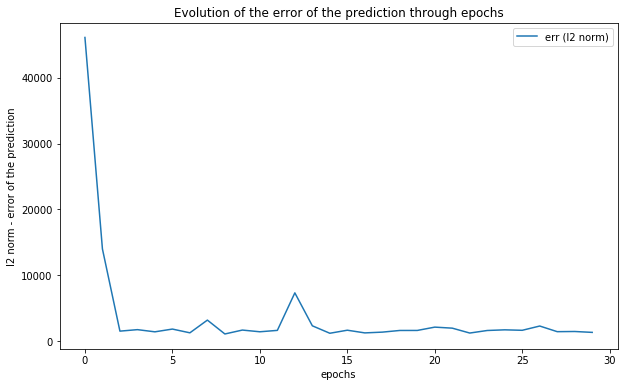

In [6]:
# Plot the accuracy as l2 norm
plt.figure(figsize=(10, 6))
plt.plot(range(nb_epoch), err_t, label="err (l2 norm)")
plt.legend(loc='best')
plt.ylabel('l2 norm - error of the prediction')
plt.xlabel('epochs')
plt.title('Evolution of the error of the prediction through epochs')
plt.show()

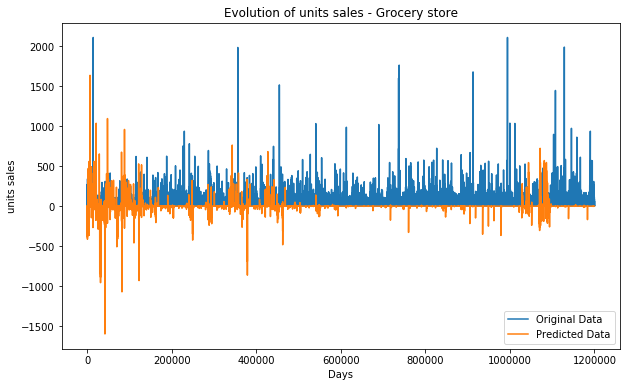

In [7]:
# Plot the prediction vs the original
plt.figure(figsize=(10, 6))
plt.plot(range(y_test.shape[0]), y_test, label="Original Data")
plt.plot(range(y_test.shape[0]), pred, label="Predicted Data")
plt.legend(loc='best')
plt.ylabel('units sales')
plt.xlabel('Days')
plt.title('Evolution of units sales - Grocery store')
plt.show()

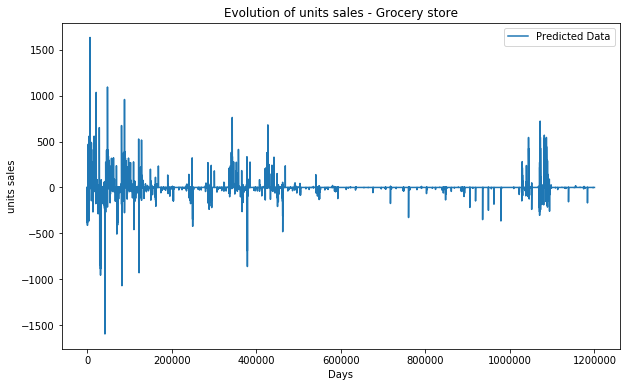

In [8]:
# Plot the only the predictions
plt.figure(figsize=(10, 6))
plt.plot(range(y_test.shape[0]), pred, label="Predicted Data")
plt.legend(loc='best')
plt.ylabel('units sales')
plt.xlabel('Days')
plt.title('Evolution of units sales - Grocery store')
plt.show()